In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train=pd.read_csv("H1_Offensive_Language_Identification_train.csv", sep=",", encoding='utf8')

In [3]:
df_train.head()

,tweet,label,id
0,@USER She should ask a few native Americans wh...,OFF,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,Amazon is investigating Chinese employees who ...,NOT,2
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4


In [4]:
df_train["label"]=df_train["label"].replace(to_replace="OFF",value=1)
df_train["label"]=df_train["label"].replace(to_replace="NOT",value=0)


In [5]:
df_train.head()

,tweet,label,id
0,@USER She should ask a few native Americans wh...,1,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,1
2,Amazon is investigating Chinese employees who ...,0,2
3,"@USER Someone should'veTaken"" this piece of sh...",1,3
4,@USER @USER Obama wanted liberals &amp; illega...,0,4


In [11]:
! pip install transformers

In [12]:
df_train['tweet_cleaned'] = df_train['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df_train.head()

,tweet,label,id,tweet_cleaned
0,@USER She should ask a few native Americans wh...,1,0,She should ask a few native Americans what the...
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,1,Go home you’re drunk!!! #MAGA #Trump2020 👊🇺🇸👊 URL
2,Amazon is investigating Chinese employees who ...,0,2,Amazon is investigating Chinese employees who ...
3,"@USER Someone should'veTaken"" this piece of sh...",1,3,"Someone should'veTaken"" this piece of shit to ..."
4,@USER @USER Obama wanted liberals &amp; illega...,0,4,Obama wanted liberals &amp; illegals to move i...


In [14]:
! pip install datasets

In [15]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/kushalj/Documents/torch-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-28 17:05:46.717993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 17:05:47.190428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 17:05:47.190445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
20

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [17]:
! pip install seaborn
import seaborn as sns

In [18]:
token_lens = []
for txt in df_train.tweet_cleaned:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/tmp/ipykernel_14404/1971794795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


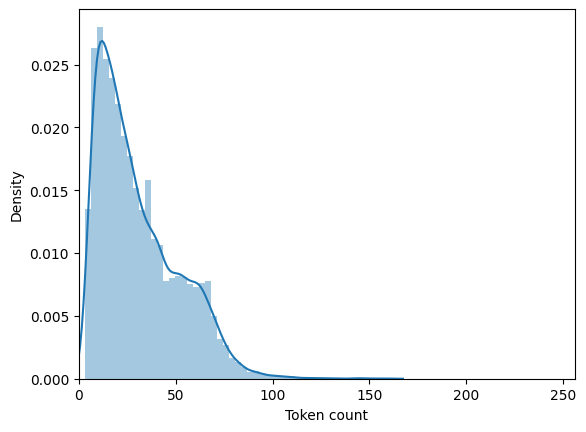

In [19]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [20]:
MAX_LEN = 160

In [21]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [22]:
from torch import nn, optim
import torch

In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [24]:
class GPReviewDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
          tweet,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'tweet_text': tweet,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [25]:
df_train, df_val = train_test_split(
  df_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [27]:
df_train.shape, df_val.shape

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    tweets=df.tweet_cleaned.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    
    return DataLoader(
    ds,
    batch_size=batch_size
    )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


/home/kushalj/Documents/torch-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

In [31]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# last_hidden_state, pooled_output = bert_model(
#   input_ids=encoding['input_ids'],
#   attention_mask=encoding['attention_mask']
# )

In [34]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax=nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [35]:
model = SentimentClassifier(2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [37]:
model = model.to(device)

In [38]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [39]:
EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/home/kushalj/Documents/torch-env/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
from collections import defaultdict

In [43]:
# %%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.4934175826859154 accuracy 0.7706445115810675
Val   loss 0.4458405346755522 accuracy 0.7930513595166163

Epoch 2/2
----------
Train loss 0.3332582945691659 accuracy 0.8637965760322256
Val   loss 0.5056190716933056 accuracy 0.790785498489426



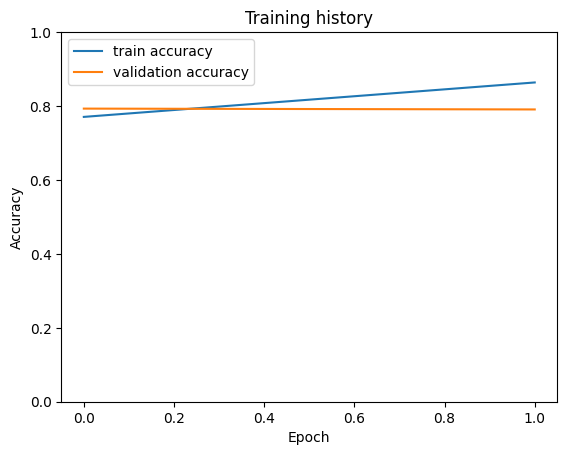

In [44]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(df_val)
)
val_acc.item()

In [46]:
def get_predictions(model, data_loader):
  model = model.eval()
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      labels = d["labels"]
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [47]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test, y_pred))

generate kaggle output

In [50]:
testDF = pd.read_csv("kaggle_test.csv")

In [51]:
testDF['label'] = np.zeros(860, dtype=int)

In [52]:
testDF.head()

,tweet,id,label
0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,0,0
1,"#ConstitutionDay is revered by Conservatives, ...",1,0
2,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,2,0
3,#Watching #Boomer getting the news that she is...,3,0
4,#NoPasaran: Unity demo to oppose the far-right...,4,0


In [53]:
testDF['tweet_cleaned'] = df_test['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
testDF.tail()

,tweet,id,label,tweet_cleaned
855,#DespicableDems lie again about rifles. Dem Di...,855,0,#DespicableDems lie again about rifles. Dem Di...
856,#MeetTheSpeakers 🙌 @USER will present in our e...,856,0,#MeetTheSpeakers ?? will present in our event ...
857,3 people just unfollowed me for talking about ...,857,0,3 people just unfollowed me for talking about ...
858,#WednesdayWisdom Antifa calls the right fascis...,858,0,#WednesdayWisdom Antifa calls the right fascis...
859,"#Kavanaugh typical #liberals , #Democrats URL",859,0,"#Kavanaugh typical #liberals , #Democrats URL"


In [54]:
test_data_loader = create_data_loader(testDF, tokenizer, MAX_LEN, BATCH_SIZE)

In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(testDF)
)
test_acc.item()

/home/kushalj/Documents/torch-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.7511627906976744

In [56]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [57]:
testDF['predictions'] = abs(y_pred - 1)

In [58]:
testDF.head()

,tweet,id,label,tweet_cleaned,predictions
0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,0,0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1
1,"#ConstitutionDay is revered by Conservatives, ...",1,0,"#ConstitutionDay is revered by Conservatives, ...",1
2,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,2,0,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,1
3,#Watching #Boomer getting the news that she is...,3,0,#Watching #Boomer getting the news that she is...,1
4,#NoPasaran: Unity demo to oppose the far-right...,4,0,#NoPasaran: Unity demo to oppose the far-right...,1


In [59]:
outputDF = testDF.drop(['tweet', 'label', 'tweet_cleaned'], axis=1)

In [60]:
outputDF.tail()

,id,predictions
855,855,1
856,856,1
857,857,0
858,858,1
859,859,1


In [61]:
outputDF = outputDF.rename(columns={'predictions': 'label'})

In [62]:
outputDF.to_csv("kaggleOutput.csv", index=False)